# UZOP - Metabolism-associated molecular clasification of hepatocellular carcinoma

Na ovom projektu cilj je napraviti klasifikator koji na temelju metaboličkih gena klasificira rak jetre.


Poveznica na članak:
https://febs.onlinelibrary.wiley.com/doi/full/10.1002/1878-0261.12639

Poveznica na upute pri izradi projekta:
https://docs.google.com/document/d/1G4L84lbYJ67w2aEUd7nmwxjcNVHjLAubFMcRRYsNY6w/edit


## 1) Priprema podataka
Cilj je raditi analizu nad metaboličkim genima.
Njega je moguće dohvatiti na sljedećoj poveznici.
https://static-content.springer.com/esm/art%3A10.1038%2Fnature10350/MediaObjects/41586_2011_BFnature10350_MOESM321_ESM.xls


Korišteni podatci su TCGA i ICGC. U članku se koristi i GEO skup podataka, ali je u uputama navedeno da se on može koristiti na kraju za validaciju **ako ostane vremena**.

In [7]:
import os
import gzip

from scipy import stats
import matplotlib.pyplot as plt
import pandas
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import median_abs_deviation
import json
import sksurv
from combat.pycombat import pycombat
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [2]:
METABOLIC_FILE = "../res/41586_2011_BFnature10350_MOESM321_ESM.xls"
def load_metabolic_genes(path: str) -> set:
    return set(pd.read_excel(
        path, sheet_name="All metabolic genes"
    )["Gene Symbol"])
mg = load_metabolic_genes(METABOLIC_FILE)

Za gene postoje anotacije koje sadrže informacije o njihovoj duljini i kojem je identifikacijskom kodu (npr. "ENSG00000176022.4") pridružen koji simbol (npr. "B3GALT6"). Može postojati nekoliko gena s istim simbolom, ali različitim duljinama i identifikacijskim kodovima. Takvi su zanemareni radi jednoznačnosti: kod onih skupova podataka koji sadrže samo simbole nije jasno na koji gen se to odnosi, tj. koju duljinu treba uzeti za normalizaciju.

In [3]:
ANNOTATIONS_FILE = "../res/gencode.v22.annotation.gtf.gz"
def load_ann(path: str, keep_symbols: set, filtering: bool = True) -> tuple:
    id_name_map = {}
    # id_len_map = {}
    name_len_map = defaultdict(list)
    name_id_map = defaultdict(list)
    with gzip.open(path, 'r') as inf:
        for line in inf:
            split_line = line.strip().split(b"\t")
            if len(split_line) < 9:
                continue
            if split_line[2] == b"gene":
                gene_info = split_line[8].strip(b";").split(b"; ")
                # assert gene_info[3].startswith(b"gene_name \"")
                gene_name = str(gene_info[3][11:len(gene_info[3]) - 1], "ascii")
                if not filtering or gene_name in keep_symbols:
                    gene_id = str(gene_info[0][9:len(gene_info[0]) - 1], "ascii")
                    gene_len = int(split_line[4]) - int(split_line[3])
                    name_len_map[gene_name].append(gene_len)
                    name_id_map[gene_name].append(gene_id)
                    id_name_map[gene_id] = gene_name
                    # id_len_map[gene_id] = gene_len

    # Ne zelimo duplikate
    # dropping_names = filter(lambda x: any(it != name_len_map[x][0] for it in name_len_map[x]), name_len_map)
    dropping_names = filter(lambda x: len(name_len_map[x]) > 1, name_len_map)

    for it in list(dropping_names):
        for gene_id in name_id_map[it]:
            # del id_len_map[gene_id]
            del id_name_map[gene_id]
        del name_id_map[it]
        del name_len_map[it]

    name_len_df = pd.DataFrame.from_dict(
        {it: jt[0] for it, jt in name_len_map.items()},
        orient="index", columns=["length"]
    )

    return id_name_map, name_len_df
inm, ld = load_ann(ANNOTATIONS_FILE, mg)

Zatim učitavamo TCGA skup podataka mičući one s identifikacijskim kodovima za koje nije definirano preslikavanje u simbole (nisu metabolički geni ili imaju više simbola pridruženih identifikacijskom kodu). Read count stupac normaliziramo TPM metodom (https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/). Kako bismo mogli povezati izračunate vrijednosti s kliničkim podatcima kasnije, učitavamo i metapodatke koji imenu datoteke pridružuju identifikacijski kod  pacijenta.

In [4]:
TCGA_FOLDER = "../res/gdc_download_20211208_083143.349897"


def add_name_index(df: pd.DataFrame, id_name_map: dict) -> None:
    df["gene_name"] = df.apply(lambda x: id_name_map[x["gene_id"]], axis=1)
    df.set_index("gene_name", inplace=True)


def remove_nameless_ids(df: pd.DataFrame, id_name_map: dict) -> None:
    df.drop(
        df[[it not in id_name_map for it in df["gene_id"]]].index, inplace=True
    )



def tpm_normalize(df: pd.DataFrame, lengths_df: pd.DataFrame):
    rpk_df = df["raw_read_count"] / lengths_df["length"]
    scaling_factor = rpk_df.count() / 1000000
    df["tpm"] = rpk_df / scaling_factor
    df.drop(columns="raw_read_count", inplace=True)   

def load_meta_tcga(path):
    with open(path, 'r') as inf:
        return {it["file_id"]: it["associated_entities"][0]["case_id"]
                for it in json.load(inf)}

def load_tcga(
        path: str,
        id_name_map: dict,
        patient_case_map: dict,
        length_df: pd.DataFrame
) -> pd.DataFrame:
    patients = pd.DataFrame(index=length_df.index.copy())
    # print(sorted(patients.index))
    # print("# of patients", len(patients.index))
    for patient in os.listdir(path):
        new_path = os.path.join(path, patient)
        if not os.path.isdir(new_path):
            continue
        patient_fn = next(filter(
            lambda x: x.endswith(".gz"),
            os.listdir(new_path)
        ))
        patient_path = os.path.join(new_path, patient_fn)
        df = pd.read_csv(
            patient_path, sep='\t', names=("gene_id", "raw_read_count")
        )
        remove_nameless_ids(df, id_name_map)
        df.dropna(axis=1, inplace=True)
        add_name_index(df, id_name_map)
        df.drop(columns="gene_id", inplace=True)
        tpm_normalize(df, length_df)
        patients[patient_case_map[patient]] = df["tpm"]
    return patients

mt = load_meta_tcga("../res/metadata.cart.2021-12-10.json")
tcga = load_tcga(TCGA_FOLDER, inm, mt, ld)

<ipython-input-4-c5d268bdc3e0>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  patients[patient_case_map[patient]] = df["tpm"]


Na sličan način je učitan icgc skup podataka, ali budući da ni za jednog pacijenta nije zabilježeno više od 2600 relevantnih gena pa je bilo null vrijednosti u tablici (što ne radi s combat algoritmom), nije korištena kasnije.

Postoji mogućnost micanja gena s nepoznatim vrijednostima, ali i to bi značajno smanjilo broj gena s kojima se raspolaže.

Dodatno, svaki pacijent (donor_id) ima dva uzorka pa bi međusobno korelirani podatci (kojih nema u TCGA skupu podataka) mogli utjecati na daljnje izračune.

In [5]:


def filter_by_gene_name(df: pd.DataFrame, keep_symbols: set):
    df.drop(
        df[[it not in keep_symbols for it in df["gene_name"]]].index, inplace=True
    )

ICGC_FILE = "../res/icgc-dataset-1638970984337/exp_seq.tsv.gz"
def load_icgc(path: str, id_name_map: dict, length_df: pd.DataFrame, keep_symbols: set) -> pd.DataFrame:
    patients = pd.DataFrame(index=length_df.index.copy())
    keep_columns = [
        "icgc_sample_id",
        "gene_id",
        "raw_read_count"
    ]
    df = pd.read_csv(
        path,
        sep="\t",
        #  index_col=["icgc_sample_id", "gene_id"],
        usecols=keep_columns
    )
    df.rename(columns={"gene_id": "gene_name"}, inplace=True)
    # df.drop_duplicates(inplace=True, ignore_index=True)
    keep_symbols = set(length_df.index)
    filter_by_gene_name(df, keep_symbols)
    df.dropna(axis=1, inplace=True)
    dfs = [it for it in df.groupby(["icgc_sample_id"])]
    # pd.set_option('display.max_columns', None)
    for i, (patient, df) in enumerate(dfs):
        # for gene_name, df2 in df.groupby(["gene_name"]):
        #     print(df2.head())
        # exit()
        df.set_index("gene_name", inplace=True)
        if len(df.index) > 2600:
            print(patient, len(df.index))
        tpm_normalize(df, length_df)
        if df.isnull().values.any():
            print("patient")
        patients[patient] = df["tpm"]
        if patients.isnull().values.any():
            continue
            print(patient)
            patients.dropna(axis=1, inplace=True)
    # print(len(patients[patients.isnull()].index.tolist()))
    return patients
icgc = load_icgc(ICGC_FILE, inm, ld, mg)

<ipython-input-5-430592496c86>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  patients[patient] = df["tpm"]


d:\programfiles\python\python_3_8_8\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


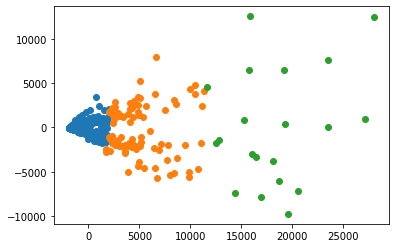

In [6]:

TCGA_CLINICAL = "../res/clinical.cart.2021-12-08/clinical.tsv"
RELEVANT_GENES = "../res/mol212639-sup-0006-tables1-s11.xlsx"

def load_clinical(path):
    return pd.read_csv(
        path,
        sep="\t",
        #  index_col=["icgc_sample_id", "gene_id"],
        # usecols=keep_columns
    )

def mad(df: pd.DataFrame, threshold: float) -> None:
    df.drop(df.loc[df.apply(
        median_abs_deviation, axis=1, raw=True
    ) <= threshold].index, inplace=True)



def relevant_genes(path: str):
    return set(
        pd.read_excel(path, sheet_name="Table S1", header=1)["Gene Symbol"]
    )

# mad(tcga, 0.5)
# cox(tcga, 1.5)

# print(tcga.head())
# icgc.dropna(axis=1, inplace=True)
# print(icgc.iloc[:20])
# total = pd.concat([tcga, icgc], join="inner", axis=1)
# batch = [0] * len(tcga.columns) + [1] * len(icgc.columns)
# data_corrected = pycombat(total, batch)

load_clinical(TCGA_CLINICAL)

# budući da ne koristim icgc dataset, odlučio sam
# nastaviti s relevantnim genima dalje kako bih dobio relevantne
# rezultate
rg = relevant_genes(RELEVANT_GENES)
X = tcga[tcga.index.isin(rg)]
# X.drop((np.abs(stats.zscore(X)) < 3).all(axis=1), inplace=True)
# print(.shape)
#print((np.abs(stats.zscore(np.sqrt(np.square(X).sum(axis=0)))) < 3))
X.drop(X.loc[(np.abs(stats.zscore(np.sqrt(np.square(X).sum(axis=1)))) > 3)].index, inplace=True)
# print(len(X.to_numpy().shape))
# print(X)
kmeans = KMeans(3, random_state=42).fit(X)
results = pandas.DataFrame(data=kmeans.labels_, columns=["cluster"], index=X.index).groupby("cluster")

reduced = PCA(2, random_state=42).fit_transform(X)
# print("r", reduced)
plt.figure()
for name, result in results:
    # print(name, X.index)
    # print(reduced[X.index.isin(result.index)])
    plt.scatter(*reduced[X.index.isin(result.index)].T)
plt.show()

classificator = SVC().fit(X, kmeans.labels_)

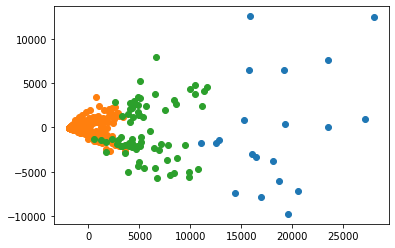

In [9]:
kmeans = AgglomerativeClustering(3).fit(X)
results = pandas.DataFrame(data=kmeans.labels_, columns=["cluster"], index=X.index).groupby("cluster")

reduced = PCA(2, random_state=42).fit_transform(X)
# print("r", reduced)
plt.figure()
for name, result in results:
    # print(name, X.index)
    # print(reduced[X.index.isin(result.index)])
    plt.scatter(*reduced[X.index.isin(result.index)].T)
plt.show()

Izgleda da ima outliera koji poremete odabir grupa. Zato klasifikator ne radi. Njih se može maknuti trimmanjem onih koji odskaču previše, ali svejedno klasifikator nije najbolji.

https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/history/policies#:~:text=TCGA%20Ethics%20%26%20Policies%20TCGA%20was%20among%20the,providing%20access%20to%20data%20from%20human%20tissue%20specimens.
